# Sample Analysis of A Single Carcassonne Game

This demonstrates some of the single-game analysis possible with the data recorded via this Carcassonne score keeping system.

It requires the `CarcassonneScore-sample.db` sqlite database in the same directory.

This script also requires the `numpy` and `matplotlib` libraries.

## Preliminaries

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from datetime import datetime

In [3]:
DBFILE = 'CarcassonneScore-sample.db'

In [4]:
timefmt = "%Y-%m-%dT%H:%M"

In [5]:
conn = sqlite3.connect(DBFILE)
cur = conn.cursor()

In [6]:
gameID = 1

## General Game Info

Load some general information about this particular game.

In [7]:
playerIDs = cur.execute('''SELECT DISTINCT playerID from turns where gameID={0:d}'''.format(gameID)).fetchall()
print("Players in game {0:d}:".format(gameID))
players = {}
for playerID in playerIDs:
    playername = cur.execute('''SELECT name FROM players WHERE playerID={0:d}'''.format(playerID[0])).fetchall()[0]
    print(playername[0])
    players[playerID[0]] = playername[0]

Players in game 1:
John Smith
Jane Doe


In [8]:
expIDs = cur.execute('''SELECT expansions FROM games WHERE gameID={0:d}'''.format(gameID)).fetchall()[0]
try:
    expIDs = [int(x) for x in expIDs[0].split(',')]
    if len(expIDs):
        print("Expansions:")
        for i, expID in enumerate(expIDs):
            expname = cur.execute('''SELECT name FROM expansions WHERE expansionID={0:d}'''.format(expID)).fetchall()[0]
            print("{0:d}) ".format(i+1) + expname[0])
except ValueError:
    print("No expansions used.")

No expansions used.


## Score Evolution

### By Turn

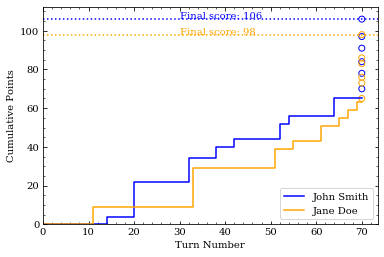

In [9]:
fig, ax = plt.subplots(1,1,
                       squeeze=False)
colors = ['blue', 'orange']
sdtype = [('turnNum', float), ('ingame', float), ('points', float)]
for i, playerID in enumerate(playerIDs):
    start = np.array((0, 1, 0), dtype=sdtype)
    rec = cur.execute('''SELECT turnNum,ingame,points FROM scores WHERE gameID={0:d} and playerID={1:d}'''.format(gameID,
                                                                                                                  playerID[0])).fetchall()
    rec = np.array(rec, dtype=sdtype)
    endT = cur.execute('''SELECT turnNum from scores WHERE gameID={0:d} ORDER BY turnNum DESC LIMIT 1'''.format(gameID)).fetchall()[0][0]
    end = np.array((endT, 1, 0), dtype=sdtype)
    rec = np.hstack((start, rec, end))
    ig = rec['ingame'] == 1
    postscore = np.sum(rec['points'][ig])
    ax[0][0].step(rec['turnNum'][ig],
                  np.cumsum(rec['points'][ig]),
                  where='post',
                  color=colors[i],
                  label=players[i])
    ax[0][0].scatter(rec['turnNum'][~ig],
                     postscore + np.cumsum(rec['points'][~ig]),
                     marker='o',
                     facecolor='',
                     edgecolor=colors[i])
    fscore = np.sum(rec['points'])
    ax[0][0].axhline(fscore,
                     ls=':',
                     color=colors[i])
    plt.annotate('Final score: {0:1.0f}'.format(fscore),
                 (30, fscore),
                 color=colors[i])
ax[0][0].set_xlabel('Turn Number')
ax[0][0].set_ylabel('Cumulative Points')
ax[0][0].set_xlim([0, rec['turnNum'][-1]*1.05])
ylims = ax[0][0].get_ylim()
ax[0][0].set_ylim([0, ylims[1]])
ax[0][0].minorticks_on()
ax[0][0].legend(loc='best')
fig.savefig('score-turn.png', bbox_inches='tight')

In [10]:
# JOIN the scores and turns tables to get the timesteps for a sample game

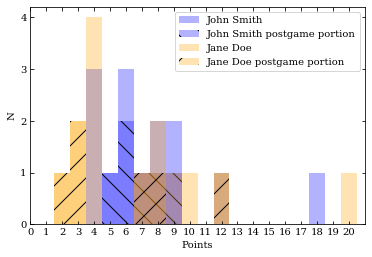

In [11]:
fig, ax = plt.subplots(1, 1,
                       squeeze=False)
hatches = ['\\', '/']
maxpts = cur.execute('''SELECT points FROM scores WHERE gameID={0:d} ORDER BY points DESC LIMIT 1'''.format(gameID)).fetchall()[0][0]
bins = np.arange(0.5, maxpts+1.5, 1)
for i, playerID in enumerate(playerIDs):
    rec = cur.execute('''SELECT points,ingame FROM scores WHERE gameID={0:d} and playerID={1:d}'''.format(gameID,
                                                                                                          playerID[0])).fetchall()
    rec = np.array(rec, dtype=[('points', float), ('ingame', float)])
    ig = rec['ingame'] == 1
    ax[0][0].hist(rec['points'],
                  bins=bins,
                  alpha=0.3,
                  color=colors[i],
                  label=players[i])
    ax[0][0].hist(rec['points'][~ig],
                  bins=bins,
                  alpha=0.3,
                  color=colors[i],
                  hatch=hatches[i],
                  label=players[i] + ' postgame portion')

ax[0][0].set_yticks(np.arange(0,5))
ax[0][0].set_xticks(np.arange(0, maxpts+1, 1))
ax[0][0].set_xlim([0, maxpts+1])
ax[0][0].set_ylabel('N')
ax[0][0].set_xlabel('Points')
ax[0][0].legend(loc='best')

## Scores by Type

### Fraction of Scores per Type

### Fraction of Points per Type

## Distribution of time per turn

Note that the sample game has only recorded times to the minute and has ommitted seconds. So the distributions will look pretty bad.

(0, 25.2)

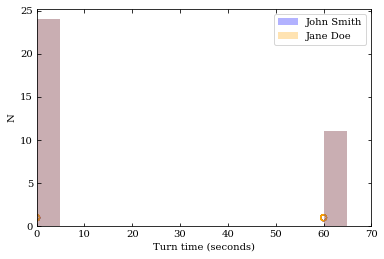

In [12]:
starttime = cur.execute('''SELECT starttime FROM games WHERE gameID={0:d}'''.format(gameID)).fetchall()[0][0]
st = datetime.strptime(starttime, timefmt)
turns = cur.execute('''SELECT time,playerID FROM turns WHERE gameID={0:d}'''.format(gameID)).fetchall()
playerdt = {}
for playerID in playerIDs:
    playerdt[playerID[0]] = []
fig, ax = plt.subplots(1, 1,
                       squeeze=False)

for i, turn in enumerate(turns):
    tt = datetime.strptime(turn[0], timefmt)
    if i > 0:
        prevt = datetime.strptime(turns[i-1][0], timefmt)
        playerdt[turn[1]].append((tt-prevt).total_seconds())
    else:
        playerdt[turn[1]].append((tt-st).total_seconds())
    
maxdt = np.max([np.max(playerdt[x]) for x in playerdt.keys()])
for i, playerID in enumerate(playerIDs):
    ax[0][0].hist(playerdt[playerID[0]],
                  bins=np.arange(0, maxdt+10, 5),
                  color=colors[i],
                  label=players[i],
                  alpha=0.3)
    ax[0][0].scatter(playerdt[playerID[0]],
                     np.ones(len(playerdt[playerID[0]])),
                     facecolor='',
                     marker='o',
                     edgecolor=colors[i])

ax[0][0].legend(loc='best')
ax[0][0].set_xlabel('Turn time (seconds)')
ax[0][0].set_ylabel('N')
ax[0][0].set_xlim([0, maxdt+10])
ylims = ax[0][0].get_ylim()
ax[0][0].set_ylim([0, ylims[1]])

## Closing

Let's cleanly close the directory.

In [13]:
conn.close()